In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import copy
import time
import logging
import argparse
import itertools
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import numpy as np
from scipy.interpolate import interpolate

sys.path.insert(0, '../network')
from measures import DataStore

In [3]:
import matplotlib.collections as mcoll

# Adopted from https://github.com/dpsanders/matplotlib-examples
def colorline(
        x, y, z=None, ax=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [4]:
directory = "2-bilinear-phase-diagram/data/"
keys=['I_ext_1','I_ext_2']
n1, n2 = 33,33
ds1 = DataStore(directory)
ds1.load()
ds1.process(keys)

  0%|          | 0/1089 [00:00<?, ?it/s]

In [5]:
def slice_data(ds, output, keys, raise_on_error=False):
    for idxs, vals in zip(
        itertools.product(*[range(len(ds.keyvals[key])) for key in keys]),
        itertools.product(*[ds.keyvals[key] for key in keys])):
        try:
            output[idxs] = ds.data[vals]
        except:
            if raise_on_error:
                raise StandardError

In [6]:
output = np.zeros((n1,n2), dtype=object)
slice_data(ds1, output, keys)

In [8]:
def rho(m, M, rbar):
    return m / np.sqrt(M-rbar**2)

In [9]:
@np.vectorize
def quality(val, combined=False, correlation=True):
    try:
        return val['q'][-1,:400].max()
    except:
        return np.NaN

In [10]:
@np.vectorize
def speed(val):
    try:
        q = val['q'][:,:400]
        idxs = q.argmax(axis=1)
        diffs = np.diff(idxs)
        diffs = diffs[np.logical_and(
            np.logical_and(
                diffs < diffs.mean()+2*diffs.std(),
                diffs > diffs.mean()-2*diffs.std()),
            diffs > 0)]
        return np.mean(diffs)
    except:
        return np.NaN

Load deterministic data

In [12]:
directory = "1-bilinear-example/data/deterministic/"
keys=['I_ext_1','I_ext_2']
ds2 = DataStore(directory)
ds2.load()
ds2.process(keys)

  0%|          | 0/2 [00:00<?, ?it/s]

Load noisy data

In [15]:
directory = "1-bilinear-example/data/noisy/"
keys=['I_ext_1','I_ext_2']
ds3 = DataStore(directory)
ds3.load()
ds3.process(keys)

  0%|          | 0/2 [00:00<?, ?it/s]

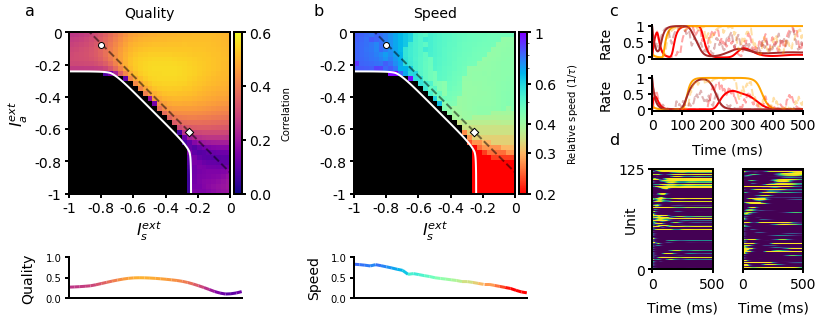

In [26]:
from matplotlib import colors as colors_

matplotlib.rcParams['axes.linewidth'] = 2

fig = plt.figure(constrained_layout=False, figsize=(12,4))
gs1 = fig.add_gridspec(nrows=4, ncols=2,
                       left=0.05, right=0.58, top=1, bottom=0,
                       hspace=1.0, wspace=0.65)
ax1 = fig.add_subplot(gs1[:-1,0])
ax2 = fig.add_subplot(gs1[:-1,1])
ax3 = fig.add_subplot(gs1[-1,0])
ax4 = fig.add_subplot(gs1[-1,1])

gs2 = fig.add_gridspec(nrows=2, ncols=1, 
                       left=0.725, right=0.9, top=0.95, bottom=0.65,
                       hspace=0.5, wspace=0.5)
gs3 = fig.add_gridspec(nrows=1, ncols=2, 
                       left=0.725, right=0.9, top=0.45, bottom=0.1,
                       hspace=0.5, wspace=0.5)

ax5 = fig.add_subplot(gs2[0,:])
ax6 = fig.add_subplot(gs2[1,:])
ax7 = fig.add_subplot(gs3[:,0])
ax8 = fig.add_subplot(gs3[:,1])

tau = 10.
q = quality(output)
s = speed(output)

x = np.arange(0,s.shape[0])
X_, Y_ = np.meshgrid(x,x)
f1 = interpolate.interp2d(x, x, q, kind='linear')
f2 = interpolate.interp2d(x, x, s, kind='linear')

x1 = np.arange(0,s.shape[0])
y1 = s.shape[0]*1.1-x1
z1 = np.hstack([f1(x1[i],y1[i]) for i in range(s.shape[0])])
z2 = tau/np.hstack([f2(x1[i],y1[i]) for i in range(s.shape[0])])

## -----------------------------------------------------------
## --------- Panels a, b (top) -------------------------------
## -----------------------------------------------------------

# Quality
cmap = copy.copy(matplotlib.cm.get_cmap("plasma"))
cmap.set_bad(color='black')
q[q<0.05] = np.NaN
im1 = ax1.imshow(q, cmap=cmap, vmin=0, vmax=0.6)
ax1.set_xlim([-0.5,s.shape[0]-0.5]);
ax1.set_ylim([-0.5,s.shape[1]-0.5]);
ax1.set_xlabel(r"$I^{ext}_s$", fontsize=16)
ax1.set_ylabel(r"$I^{ext}_a$", fontsize=16)
ax1.set_title("Quality", fontsize=14, pad=15)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im1, cax=cax1, ticks=[0,0.2,0.4,0.6]);
cb.set_label("Correlation", labelpad=10)
cb.ax.tick_params(width=2, length=4, labelsize=14)

# Speed
q[np.isnan(q)] = 0
s[q<0.05] = np.NaN
cmap = copy.copy(matplotlib.cm.get_cmap("rainbow_r"))
cmap.set_bad(color='black')
s = tau/s
im2 = ax2.imshow(s, cmap=cmap, vmin=0.20, vmax=1,
                 norm=colors_.LogNorm(vmin=s.min(), vmax=s.max()))
for ax_ in [ax1, ax2]:
    ax_.set_xticks(np.linspace(0,33,6)-0.5)
    ax_.set_yticks(np.linspace(0,33,6)-0.5)
    ax_.set_xticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0], fontsize=14)
    ax_.set_yticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0], fontsize=14)
    ax_.set_xlim([-0.5,s.shape[0]-0.5]);
    ax_.set_ylim([-0.5,s.shape[1]-0.5]);
ax2.set_xlabel(r"$I^{ext}_s$", fontsize=16)
ax2.set_title("Speed", fontsize=14, pad=15)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im2, cax=cax2, ticks=[0.2, 0.3, 0.4, 0.6, 1]);
cb.set_label(r"Relative speed ($1/\tau$)", labelpad=10)
cb.ax.set_yticklabels([0.2, 0.3, 0.4, 0.6, 1])
cb.ax.tick_params(width=2, length=4, labelsize=14)


# Capacity curve
def retrieval(theta, sigma):
    G = lambda R: np.exp(-theta**2 / (2 *
                      (R**2 + sigma**2))) / np.sqrt(2 * np.pi * (R**2 + sigma**2))
    return G(np.linspace(0,5,500))
tmp = np.zeros((100,100))
X, Y = np.meshgrid(np.linspace(-1,0,100), np.linspace(-1,0,100))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        a = retrieval(X[i,j],0.1)
        b = retrieval(Y[i,j],0.1)
        tmp[i,j] = np.max(a+b)
X_, Y_ = np.meshgrid(np.linspace(0,s.shape[0],100), np.linspace(0,s.shape[1],100))
ax1.contour(X_-0.5, Y_-0.5, tmp, levels=[1], linewidths=2, colors=['white'])
ax2.contour(X_-0.5, Y_-0.5, tmp, levels=[1], linewidths=2, colors=['white'])

# Diagonal cuts
x = np.arange(0,s.shape[0]+1)
y1 = s.shape[0]*1.1-x
ax1.plot(x, y1, linewidth=2, color='black', linestyle='dashed', alpha=0.5)
ax2.plot(x, y1, linewidth=2, color='black', linestyle='dashed', alpha=0.5)

i1, j1 = 30, 6
i2, j2 = 12, 24

for (i,j,marker) in [(i1,j1,'o'),(i2,j2,'D',)][:]:
    ax1.scatter(j,i,color='white',marker=marker, zorder=3, edgecolors='k')
    ax2.scatter(j,i,color='white',marker=marker, zorder=3, edgecolors='k')
    
## -----------------------------------------------------------
## ------- Panels a, b (bottom) ------------------------------
## -----------------------------------------------------------

colorline(x1, z1, z1, ax=ax3, cmap='plasma', norm=colors_.Normalize(vmin=0, vmax=0.6))
ax3.set_ylim([0,1.0])
ax3.set_xlim([0,s.shape[1]-1])
ax3.set_xticks([])
ax3.set_ylabel("Quality", fontsize=14, labelpad=10)

s2 = s.copy()
s2[q<2e-2] = np.NaN
s2 = tau/s
colorline(x1, z2, z2, ax=ax4, cmap='rainbow_r', norm=colors_.LogNorm(vmin=0.25, vmax=1))
ax4.set_ylabel("Speed", fontsize=14, labelpad=10);
ax4.set_ylim([0,1])
ax4.set_xlim([0,s.shape[1]-1])
ax4.set_xticks([])

## -----------------------------------------------------------
## ------- Panel c -------------------------------------------
## -----------------------------------------------------------

colors_ = ['red', 'orange', 'brown']

neuron_idxs = [25, 26, 29]

# Deterministic
for i, r in enumerate(ds2.data[(-0.0625,-0.8125)]['r'][neuron_idxs,:]):
    ax5.plot(r, color=colors_[i], linewidth=2)
for i, r in enumerate(ds2.data[(-0.625,-0.25)]['r'][neuron_idxs,:]):
    ax6.plot(r, color=colors_[i], linewidth=2)
# Noisy    
for i, r in enumerate(ds3.data[(-0.0625,-0.8125)]['r'][neuron_idxs,:]):
    ax5.plot(r, color=colors_[i], linewidth=2, linestyle='dashed', alpha=0.35)
for i, r in enumerate(ds3.data[(-0.625,-0.25)]['r'][neuron_idxs,:]):
    ax6.plot(r, color=colors_[i], linewidth=2, linestyle='dashed', alpha=0.35)
    
for ax in [ax5, ax6]:
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1], fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(width=2, length=4)
ax6.set_xticks([0,100,200,300,400,500])
ax6.set_xticklabels([0,100,200,300,400,500], fontsize=14)
ax5.set_xlim([0,500])
ax6.set_xlim([0,500])
ax5.set_ylabel("Rate", fontsize=14, labelpad=10)
ax6.set_ylabel("Rate", fontsize=14, labelpad=10)
ax5.set_xticks([])
ax6.set_xlabel("Time (ms)", fontsize=14, labelpad=10);

## -----------------------------------------------------------
## ------- Panel d -------------------------------------------
## -----------------------------------------------------------

skip_n = 80*2*2*2
state = ds2.data[(-0.0625,-0.8125)]['r']
idxs = np.argsort([np.argmax(r) for r in state])
ax7.pcolormesh(state[idxs][::skip_n,:], vmin=0.0, vmax=1.0, cmap='viridis', rasterized=True)
ax7.set_ylim([0, len(idxs)/skip_n])
ax7.set_xlim([0,500])
ax7.set_ylabel("Unit", labelpad=-20, fontsize=14)
ax7.set_xlabel("Time (ms)", fontsize=14, labelpad=10)
ax7.set_yticks([0, len(idxs)/skip_n])
ax7.set_yticklabels([0, int(len(idxs)/skip_n)], fontsize=14)
ax7.set_xticks([0,500])
ax7.set_xticklabels([0,500], fontsize=14)

state = ds2.data[(-0.625,-0.25)]['r']
idxs = np.argsort([np.argmax(r) for r in state])
ax8.pcolormesh(state[idxs][::skip_n,:], vmin=0.0, vmax=1.0, cmap='viridis', rasterized=True)
ax8.set_ylim([0, len(idxs)/skip_n])
ax8.set_xlim([0,500])
ax8.set_xlabel("Time (ms)", fontsize=14, labelpad=10)
ax8.set_yticks([])
ax8.set_xticks([0, 500])
ax8.set_xticklabels([0,500], fontsize=14);

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.tick_params(width=2, length=4)
    
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax1.annotate("a", xy=(0.03,0.95), xycoords='figure fraction', fontsize=16)
ax1.annotate("b", xy=(0.38,0.95), xycoords='figure fraction', fontsize=16)
ax1.annotate("c", xy=(0.74,0.95), xycoords='figure fraction', fontsize=16)
ax1.annotate("d", xy=(0.74,0.55), xycoords='figure fraction', fontsize=16)

fig.savefig("2.pdf", dpi=150, bbox_inches='tight')